### Projeto Covid-19

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go 

In [4]:
url = 'https://github.com/neylsoncrepalde/projeto_eda_covid/blob/master/covid_19_data.csv?raw=true'
df = pd.read_csv(url, parse_dates=['ObservationDate', 'Last Update']) #define type dates

In [11]:
import re
def corrige_colunas(col_name):
    return re.sub(r"[/| ]", "", col_name).lower()

In [12]:
df.columns = [corrige_colunas(col) for col in df.columns]

#### Função para taxa de crescimento

In [21]:
def taxa_crescimento(data, variable, data_inicio=None, data_fim=None):
    # Se data_inicio for None, define como a primeira data disponível no dataset
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    if data_fim == None:
        data_fim = data.observationdate.iloc[-1]
    else:
        data_fim = pd.to_datetime(data_fim)
    
    # Define os valores de presente e passado
    passado = data.loc[data.observationdate == data_inicio, variable].values[0]
    presente = data.loc[data.observationdate == data_fim, variable].values[0]
    
    # Define o número de pontos no tempo q vamos avaliar
    n = (data_fim - data_inicio).days
    
    # Calcula a taxa
    taxa = (presente/passado)**(1/n) - 1

    return taxa*100

def taxa_crescimento_diaria(data, variable, data_inicio=None):
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    data_fim = data.observationdate.max()
    n = (data_fim - data_inicio).days
    taxas = list(map(
        lambda x: (data[variable].iloc[x] - data[variable].iloc[x-1]) / data[variable].iloc[x-1],
        range(1,n+1)
    ))
    return np.array(taxas)*100

## Análises

### Brasil

In [14]:
# Casos confirmados no Brasil
brasil = df.loc[(df.countryregion == 'Brazil') & (df.confirmed > 0)]


In [ ]:
px.line(brasil, 'observationdate', 'confirmed', 
        labels={'observationdate':'Data', 'confirmed':'Número de casos confirmados'},
       title='Casos confirmados no Brasil')

#### Casos novos por dia

In [ ]:
# Contagem de novos casos
brasil['novoscasos'] = list(map(
    lambda x: 0 if (x==0) else brasil['confirmed'].iloc[x] - brasil['confirmed'].iloc[x-1],
    np.arange(brasil.shape[0])
))

In [ ]:
px.line(brasil, x='observationdate', y='novoscasos', title='Novos casos por dia',
       labels={'observationdate': 'Data', 'novoscasos': 'Novos casos'})

#### Número de Mortes

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=brasil.observationdate, y=brasil.deaths, name='Mortes', mode='lines+markers',
              line=dict(color='red')))
#Edita o layout
fig.update_layout(title='Mortes por COVID-19 no Brasil',
                   xaxis_title='Data',
                   yaxis_title='Número de mortes')
fig.show()

#### Taxa de Crescimento no BR

In [ ]:
tx_dia = taxa_crescimento_diaria(brasil, 'confirmed')

primeiro_dia = brasil.observationdate.loc[brasil.confirmed > 0].min()
px.line(x=pd.date_range(primeiro_dia, brasil.observationdate.max())[1:],
        y=tx_dia, title='Taxa de crescimento de casos confirmados no Brasil',
       labels={'y':'Taxa de crescimento', 'x':'Data'})

### Outras Análises

#### Séries Temporais

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

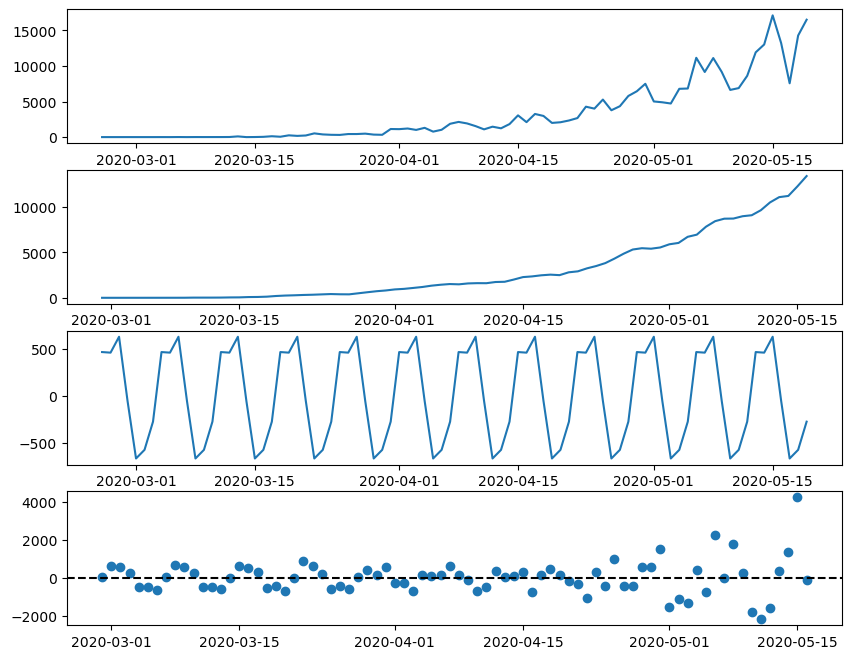

In [34]:
novoscasos = brasil.novoscasos
novoscasos.index = brasil.observationdate

res = seasonal_decompose(novoscasos)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1,figsize=(10,8))
ax1.plot(res.observed)
ax2.plot(res.trend)
ax3.plot(res.seasonal)
ax4.scatter(novoscasos.index, res.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

#### Decompondo a série de confirmados

In [28]:
confirmados = brasil.confirmed
confirmados.index = brasil.observationdate

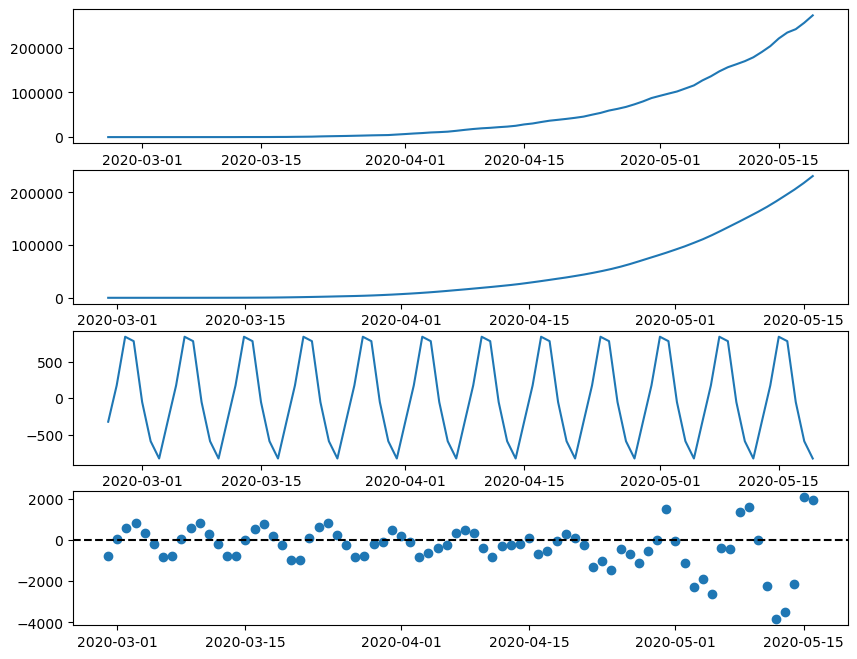

In [35]:
res2 = seasonal_decompose(confirmados)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, 1,figsize=(10,8))
ax1.plot(res2.observed)
ax2.plot(res2.trend)
ax3.plot(res2.seasonal)
ax4.scatter(confirmados.index, res2.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show()

#### Predição do n° de casos confirmados com AUTO-ARIMA

In [ ]:
!pip install pmdarima

In [26]:
from pmdarima.arima import auto_arima

In [29]:
modelo = auto_arima(confirmados)

In [36]:
pd.date_range('2020-05-01', '2020-05-19')
fig = go.Figure(go.Scatter(
    x=confirmados.index, y=confirmados, name='Observed'
))

fig.add_trace(go.Scatter(x=confirmados.index, y = modelo.predict_in_sample(), name='Predicted'))

fig.add_trace(go.Scatter(x=pd.date_range('2020-05-20', '2020-06-05'), y=modelo.predict(15), name='Forecast'))

fig.update_layout(title='Previsão de casos confirmados 15 dias',
                 yaxis_title='Casos confirmados', xaxis_title='Data')
fig.show()

#### Forecasting com Facebook Prophet

In [ ]:
!conda install -c conda-forge fbprophet -y

In [37]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'

In [ ]:
# preparando os dados
train = confirmados.reset_index()[:-5]
test = confirmados.reset_index()[-5:]

# renomeia colunas
train.rename(columns={"observationdate":"ds","confirmed":"y"},inplace=True)
test.rename(columns={"observationdate":"ds","confirmed":"y"},inplace=True)
test = test.set_index("ds")
test = test['y']

profeta = Prophet(growth="logistic", changepoints=['2020-03-21', '2020-03-30', '2020-04-25', '2020-05-03', '2020-05-10'])

#pop = 1000000
pop = 211463256 #https://www.ibge.gov.br/apps/populacao/projecao/box_popclock.php
train['cap'] = pop

# Treina o modelo
profeta.fit(train)

# Construindo previsões para o futuro
future_dates = profeta.make_future_dataframe(periods=200)
future_dates['cap'] = pop
forecast =  profeta.predict(future_dates)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat, name='Predição'))
fig.add_trace(go.Scatter(x=test.index, y=test, name='Observados - Teste'))
fig.add_trace(go.Scatter(x=train.ds, y=train.y, name='Observados - Treino'))
fig.update_layout(title='Predições de casos confirmados no Brasil')
fig.show()